# Helpful Functions

In [1]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import requests
import base64


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


In [1]:
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras import layers
from keras.callbacks import EarlyStopping
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D


Using TensorFlow backend.


In [3]:
# Read MFCCs feature CSV file of audio of 100ms block

path="/home/bsplab/Desktop/manikanta/16khz_data/NEWFRAME_SHIFTING_DATA/CNN+MFCC_newshifting/500ms/training"
#filename=os.path.join(path,"100ms_7C.csv")
df=pd.read_csv("/home/bsplab/Desktop/manikanta/16khz_data/NEWFRAME_SHIFTING_DATA/CNN+MFCC_newshifting/500ms/training/final_500ms.csv",na_values=['NA','?'])
df.columns=['MFCC0', 'MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8', 
            'MFCC9', 'MFCC10' ,'MFCC11', 'MFCC12', 'Label']
#df=pd.read_csv(filename,na_values=['NA','?'])
filename_write = os.path.join(path,"/home/bsplab/Desktop/manikanta/16khz_data/NEWFRAME_SHIFTING_DATA/CNN+MFCC_newshifting/500ms/training/output_cnnkfold_500ms.csv")
print(df.shape)
df.head()

(575855, 14)


,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12,Label
0,-0.361833,30.413287,14.026782,3.524097,-1.126189,1.995557,-2.024195,6.487043,-0.866477,7.117056,0.499036,4.950554,1.120927,AC & FAN
1,-0.314923,30.727571,14.676690,3.474063,-1.228633,2.278191,-1.999299,6.654512,-0.886767,7.060178,0.484853,4.293945,0.555153,AC & FAN
2,-0.322472,30.330372,14.470898,3.451456,-1.049604,2.263557,-2.018792,6.586320,0.119022,7.385747,0.928325,4.774701,0.638041,AC & FAN
3,-0.242023,30.538032,15.071904,3.793800,-0.413262,2.643561,-2.797349,5.827424,-0.243589,7.820150,2.213806,6.117095,0.799352,AC & FAN
4,-0.247731,30.773976,15.205313,3.309456,-1.786837,2.169586,-2.345875,5.909542,-0.580713,7.892582,1.763518,6.078295,1.073195,AC & FAN


In [4]:
print("Label has na? {}".format(pd.isnull(df['Label']).values.any()))

Label has na? False


In [5]:
df=df.dropna()
df.shape

(575855, 14)

In [6]:
print("Label has na? {}".format(pd.isnull(df['Label']).values.any()))

Label has na? False


In [7]:
# Shuffle
np.random.seed(42)# set a seed so that the results are consistent
df = df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)
df.head()

,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12,Label
0,-2.394311,29.810488,13.422348,5.041158,-0.675740,3.085593,-0.737344,5.990743,-2.730853,3.797039,-1.984848,-1.319223,-2.938877,AC & FAN
1,-1.005663,-24.179173,-39.348118,-19.687649,-33.000625,-22.143411,5.512445,-3.212025,-0.127826,-27.297233,-0.793497,-2.717658,16.901237,MUSIC
2,0.389163,-10.897454,-35.689718,-30.623394,-9.579081,-18.441173,3.574754,-9.036672,-8.098490,-18.698142,11.395906,-4.487409,13.965894,MUSIC
3,-0.421217,-5.714487,-5.557554,13.435520,-18.589183,-17.645619,-27.622267,2.044846,-24.317833,2.905796,8.945288,2.933459,-12.077112,SPEECH
4,0.061676,43.293709,10.810026,7.372252,3.384792,-4.271613,-1.987545,2.069687,-0.594472,-2.012608,-3.609498,-2.693153,-1.781564,AC & FAN


In [8]:
# Encode to a 2D matrix for training
Label = encode_text_index(df,'Label')
print("Labelling is:{}".format(Label))

############################################################################################

# Sperating Independent variable and Target Variable
x,y=to_xy(df,'Label')

Labelling is:['AC & FAN' 'CRYING' 'MUSIC' 'SPEECH']


/home/bsplab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [9]:
# Keep a 20% holdout
x_main, x_holdout, y_main, y_holdout = train_test_split(    
    x, y, test_size=0.20)

In [10]:
print("Shape of x : {}".format(x.shape))
print("Shape of y : {}".format(y.shape))
print("Shape of x_main : {}".format(x_main.shape))
print("Shape of x_holdout : {}".format(x_holdout.shape))
print("Shape of y_main : {}".format(y_main.shape))
print("Shape of y_holdout : {}".format(y_holdout.shape))

Shape of x : (575855, 13)
Shape of y : (575855, 4)
Shape of x_main : (460684, 13)
Shape of x_holdout : (115171, 13)
Shape of y_main : (460684, 4)
Shape of y_holdout : (115171, 4)


In [11]:
epochs=30
batch_size = 128
num_classes = 4
start_time = time.time()
# Cross-validate
kf = KFold(5)
    
oos_y = []
oos_pred = []
fold = 0
plot_loss = np.empty ((0,epochs))
plot_acc = np.empty ((0,epochs))

for train, test in kf.split(x_main):
    fold+=1
    print("Fold #{}".format(fold))
        
    x_train = x_main[train]
    y_train = y_main[train]
    x_test = x_main[test]
    y_test = y_main[test]
    
    X_train = np.expand_dims(x_train, axis=2) # reshape (569, 30) to (569, 30, 1) 
    #y_train = np.expand_dims(y_train, axis=2)
    #y_test = np.expand_dims(y_test, axis=2)
    X_test = np.expand_dims(x_test, axis=2)
   

    model = Sequential()
    model.add(layers.Conv1D(50,2,activation='relu',input_shape=(13,1)))
    model.add(layers.Conv1D(50,2,activation='relu'))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(100,2,activation='relu'))
    model.add(layers.Conv1D(100,2,activation='relu'))
    model.add(layers.Flatten())
    model.add(Dropout(0.2))
    model.add(layers.Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(y_train.shape[1],activation='softmax'))
    #model.summary()
    model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
    monitor = [ EarlyStopping(monitor='val_loss',
                            min_delta=1e-3,
                            patience=10,
                            verbose=0,
                            mode='auto'),ModelCheckpoint(filepath="best_weights_mycnn_500ms_mani.h5",
                                   verbose=0,
                                   save_best_only=True)] # save best model

    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks= monitor,
                        verbose=0,
                        validation_data=(X_test, y_test))
   # model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

    
   
    
    
    
    



    ####################
    pred = model.predict(X_test)
    
    oos_y.append(y_test)
    pred = np.argmax(pred,axis=1) # raw probabilities to chosen class (highest probability)
    oos_pred.append(pred)        

    # Measure this fold's accuracy
    y_compare = np.argmax(y_test,axis=1) # For accuracy calculation
    score = metrics.accuracy_score(y_compare, pred)
    print("Fold score (accuracy): {}".format(score))
    
    #######################
    elapsed_time = time.time() - start_time
    print("Elapsed time: {}".format(hms_string(elapsed_time))) 
    
    ###############################################
    loss = history.history['loss']
    #plt.plot(epochs,loss,label=='Training loss')
    acc = history.history['acc']
    plot_loss = np.append (plot_loss, [loss],axis=0)
    plot_acc = np.append (plot_acc, [acc],axis=0)
    ###############################################
    cm = confusion_matrix(y_compare,pred)
    np.set_printoptions(precision=2)
    print('Confusion matrix, without normalization')
    print(cm)

print(model.summary())
    
    
# Build the oos prediction list and calculate the error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
oos_y_compare = np.argmax(oos_y,axis=1) # For accuracy calculation

score = metrics.accuracy_score(oos_y_compare, oos_pred)

print("Final score (accuracy): {}".format(score))    
    
# Write the cross-validated prediction
oos_y = pd.DataFrame(oos_y)
oos_pred = pd.DataFrame(oos_pred)
oosDF = pd.concat( [df, oos_y, oos_pred],axis=1 )
oosDF.to_csv(filename_write,index=False)



Fold #1
Fold score (accuracy): 0.9882674712656153
Elapsed time: 0:08:13.81
Confusion matrix, without normalization
[[23160     1     0     0]
 [    0 22569   153   169]
 [    5    54 22849   347]
 [    5    91   256 22478]]
Fold #2
Fold score (accuracy): 0.9865743403844275
Elapsed time: 0:16:12.56
Confusion matrix, without normalization
[[22972     2     0     0]
 [    2 22805    93   166]
 [    3   161 22262   462]
 [    7   160   181 22861]]
Fold #3
Fold score (accuracy): 0.9882783246686999
Elapsed time: 0:24:15.31
Confusion matrix, without normalization
[[23131     0     0     0]
 [    0 22695   188   179]
 [    2    80 22575   271]
 [    1    94   265 22656]]
Fold #4
Fold score (accuracy): 0.9865417801751739
Elapsed time: 0:32:26.88
Confusion matrix, without normalization
[[23029     0     1     2]
 [    0 22550   220   209]
 [    1    41 22445   410]
 [    3    82   271 22873]]
Fold #5
Fold score (accuracy): 0.9881153946340193
Elapsed time: 0:40:44.30
Confusion matrix, without nor

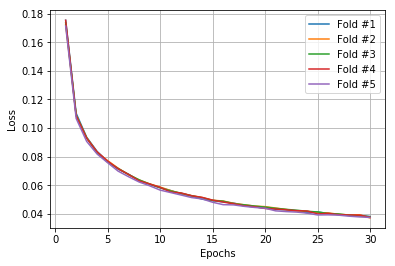

In [12]:
plot_loss_graph = plot_loss
itr=range(1,(epochs+1))
for i in range(1,fold+1):
    plt.plot(itr,plot_loss_graph[i-1],label="Fold #{}".format(i))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.savefig("k-fold_loss_cnn_500ms_mani.eps")
plt.savefig("k-fold_loss_cnn_500ms_mani.png",dpi=150)
plt.show()

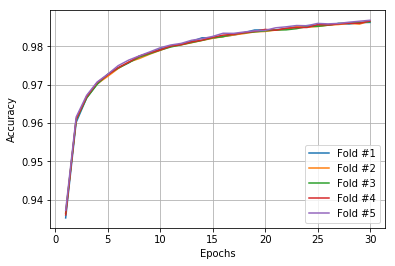

In [13]:
plt.clf()
plot_acc_graph = plot_acc
itr=range(1,(epochs+1))
for i in range(1,fold+1):
    plt.plot(itr,plot_acc_graph[i-1],label="Fold #{}".format(i))

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.savefig("k-fold_acc_cnn_500ms_mani.eps",dpi=150)
plt.savefig('k-fold_acc_cnn_500ms_mani.png',dpi=150)
plt.show()

In [14]:
# Write the cross-validated prediction (from the last neural network)
import time
tic=time.time()
X_holdout = np.expand_dims(x_holdout, axis=2)
holdout_pred = model.predict(X_holdout)
toc=time.time()
print(str(1000*(toc-tic))+"ms")


6102.401256561279ms


In [15]:
holdout_pred1 = np.argmax(holdout_pred, axis=1)
y_holdout_compare = np.argmax(y_holdout, axis=1)
score = metrics.accuracy_score(y_holdout_compare,holdout_pred1)
print("Holdout score (accuracy): {}".format(score))

Holdout score (accuracy): 0.9878962586067673


In [16]:
#X_holdout = np.expand_dims(x_holdout, axis=2)
#holdout_pred = model.predict(X_holdout)
score = metrics.log_loss(y_holdout, holdout_pred)
print("Log loss score: {}".format(score))

Log loss score: 0.03868585116481381


In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [18]:
## Turn off the scintific notation 
np.set_printoptions(suppress=True)

Confusion matrix, without normalization
[[28769     0     1     1]
 [    1 28564   171   196]
 [    1   141 28464   380]
 [    6   142   354 27980]]


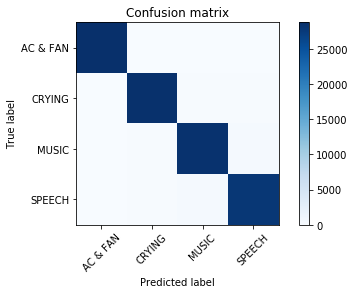

In [19]:

# Compute confusion matrix
cm = confusion_matrix(y_holdout_compare, holdout_pred1)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, Label)
plt.savefig('cm_cnn_500ms_mani.png',dpi=150)
plt.savefig('cm_cnn_500ms_mani.eps',dpi=150)



In [20]:
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_holdout_compare, holdout_pred1))  
print(classification_report(y_holdout_compare, holdout_pred1))

[[28769     0     1     1]
 [    1 28564   171   196]
 [    1   141 28464   380]
 [    6   142   354 27980]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28771
           1       0.99      0.99      0.99     28932
           2       0.98      0.98      0.98     28986
           3       0.98      0.98      0.98     28482

   micro avg       0.99      0.99      0.99    115171
   macro avg       0.99      0.99      0.99    115171
weighted avg       0.99      0.99      0.99    115171



Confusion matrix, without normalization


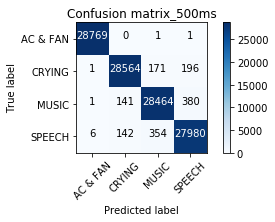

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_holdout_compare, holdout_pred1)
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure(figsize=(5,3))
plot_confusion_matrix(cnf_matrix, classes=['AC & FAN', 'CRYING','MUSIC', 'SPEECH'],
                      title='Confusion matrix_500ms')

plt.savefig('cnn_confusiponmatrix_500ms.png')

In [22]:
[[B1,C1,M1,N1],[B2,C2,M2,N2],[B3,C3,M3,N3],
 [B4,C4,M4,N4]]=cm

TP=(cm[0][0]+cm[1][1]+cm[2][2]+cm[3][3])
TN=(cm[0][0]+cm[1][1]+cm[2][2]+cm[3][3])
FP=np.sum(cm)-TP
FN=FP


Acc=(cm[0][0]+cm[1][1]+cm[2][2]+cm[3][3])/np.sum(cm)
print("Overall Accuracy: ",Acc*100)

Pr=(TP)/(TP+FP)
print("Precision: ",Pr*100)

Se=(TP)/(TP+FN)
print("Sensitivity/Recall: ",Se*100)

Sp=(TN)/(TN+FP)
print("Specificity: ",Sp*100)

ER=1-Acc
print("Error Rate: ",100*ER)

F_score = 2*TP /(2*TP + FP + FN)
print("F1-Score: ",F_score*100)

Overall Accuracy:  98.78962586067674
Precision:  98.78962586067674
Sensitivity/Recall:  98.78962586067674
Specificity:  98.78962586067674
Error Rate:  1.210374139323267
F1-Score:  98.78962586067674


In [23]:
tic=time.time()
model.save('my_CNN_500ms_mani.h5')
toc=time.time()
print(str(1000*(toc-tic))+"ms")

81.58373832702637ms


In [39]:
from keras.models import load_model
import time
tic=time.time()
my_model=load_model('my_CNN_500ms_mani.h5')
toc=time.time()
print(str(1000*(toc-tic))+"ms")

1393.791675567627ms


In [92]:
df1=pd.read_csv("/home/bsplab/Desktop/manikanta/16khz_data/NEWFRAME_SHIFTING_DATA/CNN+MFCC_newshifting/500ms/testing/crytest_500ms.csv")
df1.columns=['MFCC0', 'MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8', 'MFCC9', 'MFCC10' ,'MFCC11', 'MFCC12']
df1.head()
df1.shape

(71981, 13)

In [93]:
df2 = np.expand_dims(df1, axis=2)# We have to add 1dimension more for testing
df2.shape

(71981, 13, 1)

In [94]:
tic=time.time()
my_his1=my_model.predict(df2)
toc=time.time()
print(str(1000*(toc-tic))+"ms")

3604.186773300171ms


In [95]:
test_pred1 = np.argmax(my_his1, axis=1)
test_pred1[150:380]
print(test_pred1.shape)

(71981,)


In [96]:
c =0
for i in  test_pred1:
    if i== 1:
         c += 1
    else:
        continue 
if c > test_pred1.size/2:
    print("The tested audio is crying")
else:
    print("Error")
       
        
print("Count is " + str(c))

The tested audio is crying
Count is 51744


In [97]:
x=c/test_pred1.size
print('Accuracy is for testing with new environment data of CRYING:',100*x)

Accuracy is for testing with new environment data of CRYING: 71.8856364874064


In [98]:
df3=pd.read_csv("/home/bsplab/Desktop/manikanta/16khz_data/NEWFRAME_SHIFTING_DATA/CNN+MFCC_newshifting/500ms/testing/fanactest_500ms.csv")
df3.columns=['MFCC0', 'MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8', 'MFCC9', 'MFCC10' ,'MFCC11', 'MFCC12']
df3.head()

,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12
0,-1.147305,24.926870,25.196984,14.598969,4.701556,8.285125,-0.387873,9.159251,-1.549527,7.663207,-0.889826,4.114196,-1.260702
1,-1.264855,23.237898,30.027120,16.835693,0.792283,7.430119,-0.566533,9.629534,-2.370927,6.388160,-0.454941,2.907120,0.160224
2,-1.255745,23.550951,29.823715,16.480579,1.063072,8.235484,-0.655905,9.443653,-2.376108,6.149231,-0.587636,2.157115,-0.059677
3,-1.228085,23.886075,30.329935,16.424163,0.971652,8.169525,-0.706878,9.646453,-2.547504,5.528921,-0.723708,2.201908,-0.420058
4,-1.397908,22.029001,29.486513,17.742132,3.249137,9.685773,0.063827,9.184852,-1.831122,6.013339,-0.467628,1.773869,-1.748630


In [99]:
df4= np.expand_dims(df3, axis=2)# We have to add 1dimension more for testing
df4.shape

(71981, 13, 1)

In [100]:
tic=time.time()
my_his2=my_model.predict(df4)
toc=time.time()
print(str(1000*(toc-tic))+"ms")

3486.4816665649414ms


In [101]:
test_pred2 = np.argmax(my_his2, axis=1)
test_pred2[150:380]
print(test_pred2.shape)

(71981,)


In [102]:
c =0
for i in  test_pred2:
    if i== 0:
         c += 1
    else:
        continue 
if c > test_pred2.size/2:
    print("The tested audio is ac&fan")
else:
    print("Error")
       
        
print("Count is " + str(c))

The tested audio is ac&fan
Count is 59454


In [103]:
x=c/test_pred1.size
print('Accuracy is for testing with new environment data of ac&fan:',100*x)

Accuracy is for testing with new environment data of ac&fan: 82.59679637682166


In [104]:
df7=pd.read_csv("/home/bsplab/Desktop/manikanta/16khz_data/NEWFRAME_SHIFTING_DATA/CNN+MFCC_newshifting/500ms/testing/musictest_500ms.csv")
df7.columns=['MFCC0', 'MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8', 'MFCC9', 'MFCC10' ,'MFCC11', 'MFCC12']
df7.head()

,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12
0,0.136233,-21.402960,-25.454186,2.895125,-39.349499,16.982320,-12.056873,4.795090,3.897037,-11.572799,-4.980875,5.784769,28.804548
1,0.238459,-21.757170,-26.597538,1.907582,-38.983246,16.698487,-11.133345,6.984631,5.745933,-12.307385,-10.134391,6.409964,29.380517
2,0.406369,-22.204507,-26.661082,1.527427,-38.352845,17.471265,-12.856707,7.922898,6.859795,-12.191982,-11.659023,6.821548,30.606710
3,0.550474,-20.960420,-25.793995,1.560045,-37.519118,21.369094,-9.940701,9.826418,5.211300,-14.883692,-12.423846,7.916328,31.444307
4,0.646697,-21.985081,-27.201796,-1.861396,-37.519102,22.671990,-5.777302,9.324819,4.191169,-17.409886,-10.568379,11.364492,33.958904


In [105]:
df8 = np.expand_dims(df7, axis=2)# We have to add 1dimension more for testing
df8.shape

(71981, 13, 1)

In [106]:
tic=time.time()
my_his4=my_model.predict(df8)
toc=time.time()
print(str(1000*(toc-tic))+"ms")

3447.4284648895264ms


In [107]:
test_pred4 = np.argmax(my_his4, axis=1)
test_pred4[150:380]
print(test_pred4.shape)

(71981,)


In [108]:
c =0
for i in  test_pred4:
    if i== 2:
         c += 1
    else:
        continue 
if c > test_pred4.size/2:
    print("The tested audio is music")
else:
    print("Error")
       
        
print("Count is " + str(c))

The tested audio is music
Count is 61565


In [109]:
x=c/test_pred1.size
print('Accuracy is for testing with new environment data of music:',100*x)

Accuracy is for testing with new environment data of music: 85.52951473305455


In [110]:
df9=pd.read_csv("/home/bsplab/Desktop/manikanta/16khz_data/NEWFRAME_SHIFTING_DATA/CNN+MFCC_newshifting/500ms/testing/speechtest_500ms.csv")
df9.columns=['MFCC0', 'MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8', 'MFCC9', 'MFCC10' ,'MFCC11', 'MFCC12']
df9.head()

,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12
0,-0.645231,6.840059,-34.698966,-5.163873,-16.421513,-26.127300,-24.478998,-13.912648,-11.309976,-35.330644,-6.705617,-16.910202,-15.692434
1,-1.667391,11.200022,-23.022258,-5.891074,-34.590220,-14.549208,-21.365258,-27.976360,-15.429641,-16.015957,-8.283700,-26.623802,-17.272402
2,-1.585208,10.116967,-22.687469,-2.415676,-38.096010,-16.526405,-16.803405,-30.404819,-21.994861,-7.813076,-4.934756,-26.487692,-12.165320
3,-1.516908,7.832669,-25.530028,-6.600405,-44.508747,-23.148706,-24.789159,-36.507218,-28.861830,-11.091044,-6.928644,-26.393281,-10.738367
4,-1.507291,3.994814,-15.046565,-11.634594,-36.561951,-21.951056,-20.664525,-30.408666,-34.948488,-0.227105,-12.399686,-22.507579,-16.058356


In [111]:
df10 = np.expand_dims(df9, axis=2)# We have to add 1dimension more for testing
df10.shape

(71981, 13, 1)

In [112]:
tic=time.time()
my_his5=my_model.predict(df10)
toc=time.time()
print(str(1000*(toc-tic))+"ms")

3639.4400596618652ms


In [113]:
test_pred5 = np.argmax(my_his5, axis=1)
test_pred5[150:380]
print(test_pred5.shape)

(71981,)


In [114]:
c =0
for i in  test_pred5:
    if i== 3:
         c += 1
    else:
        continue 
if c > test_pred5.size/2:
    print("The tested audio is speech")
else:
    print("Error")
       
        
print("Count is " + str(c))

The tested audio is speech
Count is 64926


In [115]:
x=c/test_pred1.size
print('Accuracy is for testing with new environment data of speech:',100*x)

Accuracy is for testing with new environment data of speech: 90.19880246176074
